# 1. Setup

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
from skimage import io
import copy
from PIL import Image

# Interactive mode
plt.ion()   

In [3]:
torch.cuda.device_count()

4

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [5]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# 2. Definicja architektury i wag

In [6]:
resnet18 = models.resnet18(pretrained=True)

Po warstwach konwolucyjnych, mam ostatnie 2 warstwy:
- `(avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)`
- `(fc): Linear(in_features=512, out_features=1000, bias=True)`

Zostają one ostatecznie wycięte.

In [7]:
modified_resnet18 = nn.Sequential(*list(resnet18.children())[:-2])

Sprawdzanie czy wagi modelu po modyfikacji zostały zachowane:

In [8]:
list(resnet18.parameters())[:-2] == list(modified_resnet18.parameters())

True

### (Test) Zaladownanie wag innym sposobem

In [9]:
test_resnet18 = models.resnet18()
test_resnet18.load_state_dict(torch.load('/home/reflex/tmp/resnet18-5c106cde.pth'))

Czy modele są identyczne?

In [10]:
tensor_eq = []
for param1, param2 in zip(test_resnet18.parameters(), resnet18.parameters()):
    tensor_eq.append(float(param1.sum()) == float(param2.sum()))
    
all(tensor_eq)

True

### (Test) Ładowanie wag, wygenerowanych z uzyciem fast.ai

In [11]:
fastai_model_path = '/home/reflex/refleX/results/fastai_experiments/first_search_overview/models/best_resnet34_imgsize512_batch8_unfreeze.h5'
fastai_resnet34 = models.resnet34()
fastai_resnet34.load_state_dict(torch.load(fastai_model_path), strict=False)

# 3. Definicja architekury łączącej klasyfikatory

In [12]:
modified_resnet18_1 = nn.Sequential(*list(resnet18.children())[:-2])
modified_resnet18_2 = nn.Sequential(*list(resnet18.children())[:-2])

In [13]:
modified_resnet18_1 == modified_resnet18_2

False

### Wczytanie wytrenowanych wcześniej modeli

In [14]:
cartesian_resnet34_model_path = '/home/reflex/refleX/results/fastai_experiments/resnet_041218/models/best_resnet34_imgsize512_batch16_unfreeze.h5'
polar_resnet34_model_path = '/home/reflex/refleX/results/fastai_experiments/resnet_polar_041218/models/best_resnet34_imgsize512_batch8_unfreeze.h5'

modified_resnet18_1.load_state_dict(torch.load(cartesian_resnet34_model_path), strict=False)
modified_resnet18_2.load_state_dict(torch.load(polar_resnet34_model_path), strict=False)

Wylaczenie gradientu

In [15]:
for param in modified_resnet18_1.parameters():
    param.requires_grad = False
    
for param in modified_resnet18_2.parameters():
    param.requires_grad = False

Ostatnie warstwy w implementacji **fast.ai**

`
      (8): AdaptiveConcatPool2d(
        (ap): AdaptiveAvgPool2d(output_size=(1, 1))
        (mp): AdaptiveMaxPool2d(output_size=(1, 1))
      )
      (9): Flatten()
      (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
      (11): Dropout(p=0.5)
      (12): Linear(in_features=1024, out_features=512, bias=True)
      (13): ReLU()
      (14): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
      (15): Dropout(p=0.5)
      (16): Linear(in_features=512, out_features=7, bias=True)
      (17): Sigmoid()
`

Sieć przyjmuje 2 niezależne obiekty przycietej sieci ResNet, łączy wyniki w jeden wektor, przepuszcza to przez warstwę FC, która na wyjściu generuje 7 wyników.

In [16]:
class FastAIAdaptiveConcatPool2d(nn.Module):
    def __init__(self, size=(1, 1)):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(size)
        self.mp = nn.AdaptiveMaxPool2d(size)
        
    def forward(self, x): 
        return torch.cat([self.mp(x), self.ap(x)], 1)

class refleXNet(nn.Module):
    def __init__(self, resnet_output_size=512, vector_size=1680, num_output_featues=7, skip_vectors=False, vector_output_layer_size=256):
        super(refleXNet, self).__init__()
        
        """
            Args:
            ----------
                resnet_output_size         - jakiego rozmiaru wyjciowego spodziewamy sie resnecie.
                vector_size                - pelny rozmiar wektora wchodzacego (drugi wymiar to naturalnie 1).
                num_output_features        - rozmiar ostatniej (wyjsciowej warstwy).
                skip_vectors               - bool, decyduje czy pomijamy wektory w naszej sieci czy nie.
                vector_output_layer_size   - rozmiar wyjsciowej warstwy podsieci do wektorow.
        """
        
        self.include_vectors = not bool(skip_vectors)
        self.normal_resnet = modified_resnet18_1
        self.polar_resnet = modified_resnet18_2
        self.fastai_adap_concat_pool2d = FastAIAdaptiveConcatPool2d()
        self.num_output_featues = num_output_featues
        
        last_block_input_size = 4 * resnet_output_size + (vector_output_layer_size * int(self.include_vectors))
        
        """ Mala podsiec FC, ktora dziala tylko na wektorach """
        self.vector_layers = nn.Sequential(
            
            # Podzielic na "block"? Wtedy dodatkowy parametr -> ilosc blokow + rozmiary blokow. 
            nn.BatchNorm1d(vector_size, eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(),
            nn.Linear(in_features=vector_size, out_features=768, bias=True),
            nn.ReLU(),
            
            nn.BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(),
            nn.Linear(in_features=768, out_features=512, bias=True),
            nn.ReLU(),
            
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(),
            nn.Linear(in_features=512, out_features=vector_output_layer_size, bias=True),
            nn.ReLU()
        )
        
        """ Ostatnie warstwy sieci, wzorowane na fast.ai """
        self.output_layers = nn.Sequential(
            nn.BatchNorm1d(last_block_input_size, eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(),
            nn.Linear(in_features=last_block_input_size, out_features=512, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(),
            nn.Linear(in_features=512, out_features=self.num_output_featues, bias=True),
            nn.ReLU()
            
            # Gdzieś czytałem, że BCEWithLogitsLoss samodzielnie dodaje na koncu Sigmoid,
            # wiec dodawanie Sigmoidu na sile w naszej sieci mija się z celem w tej chwili
            # (DO ROZWIAZANIA!)
            
            # BCEWithLogitsLoss() is a natural choice for your application because 
            # it applies a Sigmoid function to the output before calculating cross entropy loss.
            
            # Zrodla:
            # https://discuss.pytorch.org/t/loss-function-crossentropyloss-vs-bcewithlogitsloss/16089/2
            # https://discuss.pytorch.org/t/whats-the-difference-between-sigmoid-bceloss-and-bcewithlogitsloss/13611
            
            # nn.Sigmoid()           
        )
 
        
    def forward(self, x, y, v):
        
        # TO READ:
        # https://forums.fast.ai/t/what-is-the-distinct-usage-of-the-adaptiveconcatpool2d-layer/7600
        
        # (8)
        x_1 = self.fastai_adap_concat_pool2d(self.normal_resnet(x))
        x_2 = self.fastai_adap_concat_pool2d(self.polar_resnet(y))
             
        # (9)
        x = torch.cat((x_1, x_2), 1) 
        x = x.view(x.size(0), -1)
        
        if self.include_vectors:
            v = self.vector_layers(v)
            x = torch.cat((x, v), 1)
        
        # (10)+
        x = self.output_layers(x)
        
        return x

In [17]:
refleXNet()

refleXNet(
  (normal_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# 4. Definicja ładowania danych (datasetu)

In [18]:
class refleXDataset(Dataset):

    def __init__(self, csv_file, root_dir, original_imgs_dir, polar_imgs_dir, vectors_dir, transform=None):
        
        # Plik CSV -> Mapowanie: obraz -> anomalie
        self.csv = pd.read_csv(csv_file)
        
        # Klasy
        self.classes = list(self.csv)[1:]
        
        # Lokalizacja obrazow
        self.root_dir = root_dir 
        self.original_imgs_dir = original_imgs_dir
        self.polar_imgs_dir = polar_imgs_dir
        self.vectors_dir = vectors_dir
        
        # Transformacja danych wejsciowych
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
                
        img_name = self.csv.iloc[idx, 0]
        original_img_path = os.path.join(self.root_dir, self.original_imgs_dir, img_name)
        polar_img_path = os.path.join(self.root_dir, self.polar_imgs_dir, img_name)
        vector_path = os.path.join(self.root_dir, self.vectors_dir, img_name)
        
        original_img = Image.open(original_img_path + ".png").convert("RGB")
        polar_img = Image.open(polar_img_path + ".png").convert("RGB")
        vector = Image.open(vector_path + ".png").convert("L").getdata()
        
        vector_as_tensor = torch.from_numpy(np.array(vector, dtype=np.float32) / 255).float()
        
        labels = self.csv.iloc[idx, 1:].values
        labels = labels.astype('float').reshape(-1)

        if self.transform:
            original_img = self.transform(original_img)
            polar_img = self.transform(polar_img)
            
        output = [img_name, original_img, polar_img, vector_as_tensor, labels]

        return output

# 5. Łącznie wszystkich elementów w całość

## 5.1 Dataset loader

Co do transformacji, autor przykładu używa dodatkowo:
- `transforms.RandomResizedCrop(224)` (augumentacja)
- `transforms.RandomHorizontalFlip()` (augumentacja)


- **`transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])` (normalizacja - potrzebna ? # TODO!)**
    

In [ ]:
stages = ['train', 'test', 'validate']

csvs = {stage: os.path.join('/home/reflex/refleX/metadata/csv', stage + '.csv') for stage in stages}

root_data_dir = '/home/reflex/refleX/metadata/labeled'
original_imgs_dir = 'original512'
polar_imgs_dir = 'polar512'
vectors_dir = 'vectors/concatenated'

In [ ]:
csvs

{'train': '/home/reflex/refleX/metadata/csv/train.csv',
 'test': '/home/reflex/refleX/metadata/csv/test.csv',
 'validate': '/home/reflex/refleX/metadata/csv/validate.csv'}

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validate': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {stage: refleXDataset(csvs[stage], root_data_dir, original_imgs_dir, polar_imgs_dir, vectors_dir, data_transforms[stage]) for stage in stages}
dataloaders = {stage: torch.utils.data.DataLoader(image_datasets[stage], batch_size=4, shuffle=True, num_workers=4) for stage in stages}

In [ ]:
dataset_sizes = {stage: len(image_datasets[stage]) for stage in stages}
class_names = image_datasets['train'].classes
class_names

['loop_scattering',
 'background_ring',
 'strong_background',
 'diffuse_scattering',
 'artifact',
 'ice_ring',
 'non_uniform_detector']

In [ ]:
img_name, original_imgs, polar_imgs, vectors, labels = next(iter(dataloaders[stages[0]]))
original_imgs = torchvision.utils.make_grid(original_imgs)
polar_imgs = torchvision.utils.make_grid(polar_imgs)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.permute(1, 2, 0).numpy()
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    
    plt.figure(figsize=(15, 15))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

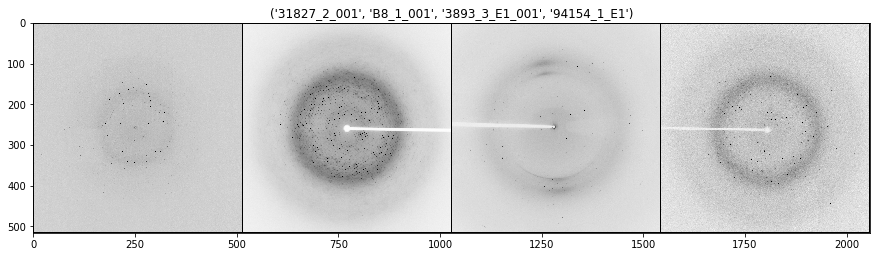

In [ ]:
imshow(original_imgs, title=img_name)

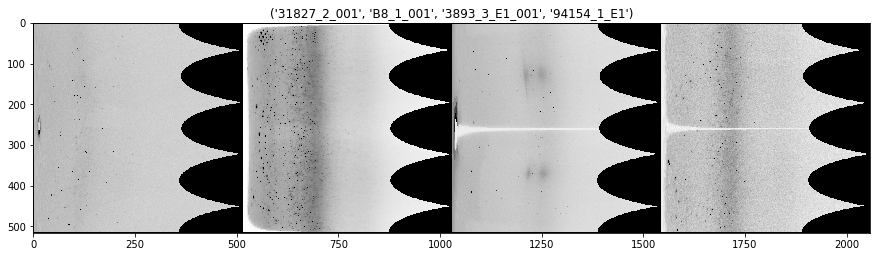

In [ ]:
imshow(polar_imgs, title=img_name)

In [ ]:
for img, lab in zip(img_name, labels):
    print(img, lab)

31827_2_001 tensor([0., 1., 0., 0., 0., 0., 1.], device='cpu', dtype=torch.float64)
B8_1_001 tensor([0., 1., 0., 1., 0., 0., 1.], device='cpu', dtype=torch.float64)
3893_3_E1_001 tensor([1., 1., 0., 0., 0., 0., 0.], device='cpu', dtype=torch.float64)
94154_1_E1 tensor([0., 1., 0., 1., 0., 0., 1.], device='cpu', dtype=torch.float64)


### Parametry i loss

In [ ]:
# Net
model = refleXNet()
_ = model.to(device)

In [ ]:
# Loss
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [ ]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validate']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for _, orignal_img, polar_img, vectors, labels in dataloaders[phase]:
                orignal_img = orignal_img.to(device)
                polar_img = polar_img.to(device)
                vectors = vectors.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(orignal_img, polar_img, vectors)
                    labels = labels.float()
                    
                    # Klasyfikacja wieloetykietowa !
                    # _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * orignal_img.size(0)
            
                # Ma sens?
                threshold = 0 
                preds = (outputs > threshold).float()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validate' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
best_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=128)

Epoch 0/127
----------
train Loss: 0.6516 Acc: 5.1653
validate Loss: 0.6296 Acc: 5.9300

Epoch 1/127
----------
train Loss: 0.6260 Acc: 5.7631
validate Loss: 0.6277 Acc: 5.8900

Epoch 2/127
----------
train Loss: 0.6255 Acc: 5.8055
validate Loss: 0.6266 Acc: 5.9450

Epoch 3/127
----------
train Loss: 0.6192 Acc: 5.8776
validate Loss: 0.6218 Acc: 5.9800

Epoch 4/127
----------
train Loss: 0.6212 Acc: 5.8892
validate Loss: 0.6408 Acc: 5.8000

Epoch 5/127
----------


---

___

---

In [ ]:
"""
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    """